<a href="https://colab.research.google.com/github/khickey25/nlp_shap_notebooks/blob/master/nlp_shap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip install shap
!pip install lime

     |████████████████████████████████| 276kB 8.4MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394125 sha256=375c7e3398ba6adbc3607a8f6ea01fd72cd54b65a1fe2838555887829df9270b
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap
     |████████████████████████████████| 276kB 7.6MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=369054081a217f8f481df58a0b7acc8a04c84a5c600542b1f6bcb5068f7d0f6d
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:

import pandas as pd
%tensorflow_version 1.13.1
import tensorflow as tf
from tensorflow.keras.preprocessing import text
import keras.backend.tensorflow_backend as K
K.set_session
import matplotlib.pyplot as plt
import shap
import numpy
import sklearn.metrics as skm
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier



`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.13.1`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
text_train_path = "/content/drive/My Drive/test_data/text_train.csv"
text_test_path = "/content/drive/My Drive/test_data/text_test.csv"
y_train_path = "/content/drive/My Drive/test_data/y_train.csv"
y_test_path = "/content/drive/My Drive/test_data/y_test.csv"

text_train = pd.read_csv(text_train_path, names=['text'])
text_test = pd.read_csv(text_test_path, names=['text'])
y_train = pd.read_csv(y_train_path)
y_test = pd.read_csv(y_test_path)

baseline_model_shap_vals = numpy.load("/content/drive/My Drive/test_data/shap_vals.npy")

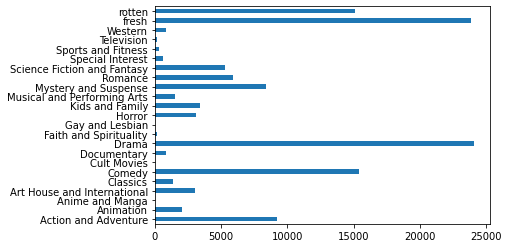

In [ ]:
pd.concat([text_train, y_train], axis=1).iloc[:, 1:].sum(axis = 0, skipna = True).plot(kind='barh')

In [ ]:

class TextPreprocessor(object):
    def __init__(self, vocab_size):
        self._vocab_size = vocab_size
        self._tokenizer = None
    def create_tokenizer(self, text_list):
        tokenizer = text.Tokenizer(num_words = self._vocab_size)
        tokenizer.fit_on_texts(text_list)
        self._tokenizer = tokenizer
    def transform_text(self, text_list):
        text_matrix = self._tokenizer.texts_to_matrix(text_list)
        return text_matrix

def read_data():
  text_train_path = "/content/drive/My Drive/test_data/text_train.csv"
  text_test_path = "/content/drive/My Drive/test_data/text_test.csv"
  y_train_path = "/content/drive/My Drive/test_data/y_train.csv"
  y_test_path = "/content/drive/My Drive/test_data/y_test.csv"

  text_train = pd.read_csv(text_train_path, names=['text'])
  text_test = pd.read_csv(text_test_path, names=['text'])
  y_train = pd.read_csv(y_train_path)
  y_test = pd.read_csv(y_test_path)

  return text_train, text_test, y_train, y_test




def preprocess_text(vocab_size, text_train, text_test, processor):
  #train_post = merged['Body'].values[: train_size]
  #test_post = merged['Body'].values[train_size: ]
  processor.create_tokenizer(text_train.text)
  X_train = processor.transform_text(text_train.iloc[:,0])
  X_test = processor.transform_text(text_test.iloc[:,0])
  return X_train, X_test
  
def word_lookup_creation(processor):
  words = processor._tokenizer.word_index
  word_lookup = list()
  for i in words.keys():
      word_lookup.append(i)
  word_lookup = [''] + word_lookup
  return words, word_lookup
  
def create_model(input_shape, num_tags):
  tf.random.set_random_seed(2020)
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(50, input_shape = (input_shape,), activation='relu'))
  model.add(tf.keras.layers.Dense(25, activation='relu'))
  model.add(tf.keras.layers.Dense(num_tags, activation='sigmoid'))
  model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
  return model

def train_and_score(model, train_data_X, train_data_y, test_data_X, test_data_y, 
                    n_epochs, batch_size):
  model.fit(train_data_X, train_data_y, epochs=n_epochs, batch_size=batch_size, 
            validation_split=0.1)
  print('Eval loss/accuracy:{}'.format(model.evaluate(test_data_X, test_data_y,
                                                      batch_size = batch_size)))

  return model




def shap_vals_calculation(n_examples : int, n_explanations : int, 
                          x_train : numpy.ndarray, x_test : numpy.ndarray,
                          model : tf.python.keras.engine.sequential.Sequential):
  #check if file already exists; if not, create it
  print("[INFO] Calculating Shap Values...\n")
  attrib_data = x_train[:n_examples]
  explainer = shap.DeepExplainer(model, attrib_data)
  shap_vals = explainer.shap_values(x_test[:n_explanations])
  return shap_vals, explainer

def display_shap_figures(shap_values, x_test, word_lookup_reference):
  shap.summary_plot(shap_values, feature_names=word_lookup_reference, 
                    class_names=y_train.columns)

  for i in range(len(shap_values)):
    print(y_test.columns[i])
    shap.summary_plot(shap_values[i], x_test[:shap_values[0].shape[0]],
                      feature_names=word_lookup_reference, 
                      class_names=y_train.columns)






  

## Baseline Model Shap Figures

Due to computation complexity, a baseline model was trained and subsequent shap values were calculated for all features. This allows for a fuller explanation of words for comparison puroses.

In [ ]:
#code to recreate the train and test data that was used
#to calculate baseline model shap values
vocab_size=2000
text_train, text_test, y_train, y_test = read_data()
num_tags = y_test.shape[1]

print("[INFO] Processing Text...\n")
processor = TextPreprocessor(vocab_size=vocab_size)
X_train, X_test = preprocess_text(vocab_size=vocab_size, text_train=text_train,
                                  text_test=text_test, processor=processor)
word_dict, word_lookup = word_lookup_creation(processor=processor)




print("[INFO] Displaying Figures...")
display_shap_figures(shap_values=[x for x in baseline_model_shap_vals], x_test=X_test,
                      word_lookup_reference=word_lookup)


In [ ]:
#main function to train model on specified datasets. 
#make list of features to remove from training sets and retrain
#model for performance comparison

def main(vocab_size=2000, drop_features=None):
    text_train, text_test, y_train, y_test = read_data()
    num_tags = y_test.shape[1]
    
    print("[INFO] Processing Text...\n")
    processor = TextPreprocessor(vocab_size=vocab_size)
    X_train, X_test = preprocess_text(vocab_size=vocab_size, text_train=text_train,
                                      text_test=text_test, processor=processor)
    word_dict, word_lookup = word_lookup_creation(processor=processor)
    
    if drop_features:
      X_train = numpy.delete(X_train, list(word_dict[k] for k in drop_features), 1)
      X_test = numpy.delete(X_test, list(word_dict[k] for k in drop_features), 1)
      word_lookup = [w for w in word_lookup if w not in drop_features]
      vocab_size -= len([x for x in drop_features])
    
    print("[INFO] Creating and Training Model...\n")
    model = create_model(input_shape=vocab_size, num_tags=num_tags)
    
    trained_model = train_and_score(model, train_data_X=X_train, train_data_y=y_train, 
                                    test_data_X=X_test, test_data_y=y_test,
                                    n_epochs=10, batch_size=128)
    y_pred = trained_model.predict(X_test)
    
    print("[INFO] Displaying Confusion Matrix ...\n")
    cm = skm.multilabel_confusion_matrix(y_test.values, y_pred.round(0))
    cm_df = pd.DataFrame(cm.reshape(cm.shape[0], -1), columns=['TN', 'FP', 'FN', 'TP'], 
                         index=y_test.columns)
    print(cm_df, "\n")
    print("[INFO] Displaying Classification Report...\n")
    print(skm.classification_report(y_test.values, y_pred.round(0), target_names=cm_df.index))

    if drop_features:      
      shap_vals = shap_vals_calculation(n_examples=500, n_explanations=50, 
                                        x_train=X_train, x_test=X_test, 
                                        model=trained_model)
      
      print("[INFO] Displaying Figures...")
      display_shap_figures(shap_values=shap_vals, x_test=X_test,
                          word_lookup_reference=word_lookup)
    
  


In [ ]:
#@title
#run for model performance metrics 
#shap values figures are above
main(vocab_size=2000)

[INFO] Processing Text...

[INFO] Creating and Training Model...

Train on 35103 samples, validate on 3901 samples
Epoch 1/10
35103/35103 [==============================] - 1s 33us/sample - loss: 0.2514 - acc: 0.8941 - val_loss: 0.1149 - val_acc: 0.9569
Epoch 2/10
35103/35103 [==============================] - 1s 29us/sample - loss: 0.0898 - acc: 0.9657 - val_loss: 0.0718 - val_acc: 0.9730
Epoch 3/10
35103/35103 [==============================] - 1s 30us/sample - loss: 0.0642 - acc: 0.9741 - val_loss: 0.0599 - val_acc: 0.9761
Epoch 4/10
35103/35103 [==============================] - 1s 30us/sample - loss: 0.0549 - acc: 0.9771 - val_loss: 0.0555 - val_acc: 0.9764
Epoch 5/10
35103/35103 [==============================] - 1s 28us/sample - loss: 0.0499 - acc: 0.9788 - val_loss: 0.0524 - val_acc: 0.9770
Epoch 6/10
35103/35103 [==============================] - 1s 28us/sample - loss: 0.0465 - acc: 0.9801 - val_loss: 0.0510 - val_acc: 0.9774
Epoch 7/10
35103/35103 [===========================

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.


## Test 1:
### Remove top 5 features from global importances:
- comedi
- date
- love
- norp
- thriller

 
### Results: No discernable drop in performance in terms of classifying genres. However, some change in performance of predicting rotten or fresh.

Percent Change:
- Fresh: 
    - Precision: 0.81=>0.81
    - Recall: 0.84=>0.82
    - F1 Score: 0.82=>0.82
- Rotten:
    - Precision: 0.74=>0.72
    - Recall: 0.68=>0.71
    - F1 Score: 0.71=>0.71

Seems that the model is predicting more rotten verdicts or predicting less fresh verdicts in general, which is might be a change in performance or might just be due to randomness.

In [ ]:
#@title
#TEST 1: 
main(drop_features=['comedi', 'date', 'love', 'norp', 'thriller'])

## Test 2: Drop 20 most important words
- comedi
- date
- love
- norp
- thriller
- gpe
- life
- adventur
- anim
- seri
- drama
- man
- make
- fun
- beauti
- director
- enjoy
- young
- tri
- come

### Results: Again, no discernable change in performance. Only slight (~.01-.03) change in precision/recall/f1 scores for rotten/fresh prediction scores. The new features (21st most important and lower) shap values appearing in shap global summary plot are becoming very low, almost not really informative.

In [ ]:
#@title
main(drop_features=['comedi', 'date', 'love', 'norp', 'thriller',
                    'gpe', 'life', 'adventur', 'anim', 'seri',
                    'drama', 'man', 'make', 'fun', 'beauti', 
                    'director', 'enjoy', 'young', 'tri', 'come'])

## Test 3: Remove important words for particular genre of film.

Remove 20 most important shap-derived features in "Comedy" genre and see if model has change in performance in classifiying the genre. 

Results: No change in performance; metrics are virtually identical.

In [ ]:
#@title
#Test 3: Comdedy Genre
main(drop_features=['comedi', 'drama', 'thriller', 'director', 'set',
                    'comic', 'live', 'cardin', 'adapt', 'stori', 
                    'attempt', 'man', 'wife', 'young', 'night',
                    'seri', 'colleg', 'date', 'mother', 'back'])

## Test 4: Removing top 20 words/features for Fresh/Rotten classification

Remove the top 20 words that influence the prediction of fresh.

Results: Again, not much change in performance; if anything, a slight disimprovement of "rotten" prediction performance. But again, this may be in part due to randomness. 

__Baseline__:
- fresh       
  - Precision 0.81
  - Recall 0.84
  - F1 0.82      
- rotten
  - Precision 0.74
  - Recall 0.68
  - F1 0.71

__Removed__:
- fresh       
  - Precision 0.79
  - Recall 0.86
  - F1 0.82      
- rotten
  - Precision 0.74
  - Recall 0.65
  - F1 0.69


In [ ]:
#@title
main(drop_features=['enjoy', 'date', 'fun', 'love', 'tri',
                    'perfect', 'best', 'make', 'start', 'unfortun',
                    'classic', 'entertain', 'power', 'seem', 'life',
                    'funni', 'film', 'movi', 'gpe', 'school'])

# 2nd Strategy

### Instead of removing features, perturb the values of 1 with values of 0. 

For instances in the indicated word dataframe column, if said word appears in the review vector, its value of 1 will instead be substituted with 0 in the vector. 

Ex: if the first sentence in our corpus is: "I really like this comedy", then the value of _df.loc[0, "comedy"]_ is equal to 1. This strategy will substitute that value to 0 and let classifier be trained with said pertubation(s). 

In [ ]:
#main function to train model on specified datasets. 
#make list of features to remove from training sets and retrain
#model for performance comparison

def main2(vocab_size=2000, drop_features=None):
    text_train, text_test, y_train, y_test = read_data()
    num_tags = y_test.shape[1]
    
    print("[INFO] Processing Text...\n")
    processor = TextPreprocessor(vocab_size=vocab_size)
    X_train, X_test = preprocess_text(vocab_size=vocab_size, text_train=text_train,
                                      text_test=text_test, processor=processor)
    word_dict, word_lookup = word_lookup_creation(processor=processor)
    
    if drop_features:
      drop_word_indicies = [word_dict[w] for w in drop_features]
      X_train[:,drop_word_indicies] = numpy.where(X_train[:,drop_word_indicies] == 1, 0, 0)
    
    print("[INFO] Creating and Training Model...\n")
    model = create_model(input_shape=vocab_size, num_tags=num_tags)
    
    trained_model = train_and_score(model, train_data_X=X_train, train_data_y=y_train, 
                                    test_data_X=X_test, test_data_y=y_test,
                                    n_epochs=10, batch_size=128)
    y_pred = trained_model.predict(X_test)
    
    print("[INFO] Displaying Confusion Matrix ...\n")
    cm = skm.multilabel_confusion_matrix(y_test.values, y_pred.round(0))
    cm_df = pd.DataFrame(cm.reshape(cm.shape[0], -1), columns=['TN', 'FP', 'FN', 'TP'], 
                         index=y_test.columns)
    print(cm_df, "\n")
    print("[INFO] Displaying Classification Report...\n")
    print(skm.classification_report(y_test.values, y_pred.round(0), target_names=cm_df.index))

    if drop_features:      
      shap_vals = shap_vals_calculation(n_examples=500, n_explanations=50, 
                                        x_train=X_train, x_test=X_test, 
                                        model=trained_model)
      
      print("[INFO] Displaying Figures...")
      display_shap_figures(shap_values=shap_vals, x_test=X_test,
                          word_lookup_reference=word_lookup)
    
  


## Test 1a: Perturb values of top 5 most important words/features

Perturb the vector values to 0 for instances where the top 5 ranked words appears in a particular review.

__Results__: No real change in performance. 

In [ ]:
#@title
#Test 1a: remove 5 most important features
main2(drop_features=['comedi', 'date', 'norp', 'thriller', 'love'])

## Test 2a: Perturb top 20 most important features

__Results__: No real change in performance. Appears that classifier predicts "rotte" a little more frequently compared to baseline, but other performance metrics are indestinguishable. 

In [ ]:
#@title
#test 2a
main2(drop_features=['comedi', 'date', 'love', 'norp', 'thriller',
                    'gpe', 'life', 'adventur', 'anim', 'seri',
                    'drama', 'man', 'make', 'fun', 'beauti', 
                    'director', 'enjoy', 'young', 'tri', 'come'])

## Test 3a: Perturb top 20 words from one particular genre (Comedy)

__Results__: Comedy genre precision/recall/f1 scores are the same as baseline performer. Note that the new most important words have changed, but their respective shap values are similar to most important ones from baseline. 

In [ ]:
#@title
#Test 3a: Comdedy Genre
main2(drop_features=['comedi', 'drama', 'thriller', 'director', 'set',
                    'comic', 'live', 'cardin', 'adapt', 'stori', 
                    'attempt', 'man', 'wife', 'young', 'night',
                    'seri', 'colleg', 'date', 'mother', 'back'])

## Test 4s: Perturb most important features for rotten/fresh category

__Results__: Same as before; results ultimately are the same as baseline performance. 

In [ ]:
#@title
#test 4a
main(drop_features=['enjoy', 'date', 'fun', 'love', 'tri',
                    'perfect', 'best', 'make', 'start', 'unfortun',
                    'classic', 'entertain', 'power', 'seem', 'life',
                    'funni', 'film', 'movi', 'gpe', 'school'])